# Progetto Corò Elia

In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from utils.print_correlation_matrix import PrintCorrelationMatrix

from cleaning.fill_missing_values import fill_missing_values
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns
from cleaning.one_hot_encoder import OneHotEncoderFunction


## Data Initial Cleaning

In [2]:
# Carica i dati
data = pd.read_csv('train.csv')

# Mantieni solo le colonne presenti nel set di test
# Questa operazione potrebbe rimuovere colonne se 'train.csv' ha colonne extra
test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
data = data[test_columns]

# Rimuovi la colonna 'id'
data = data.drop(columns=['id'])

# Rimuovi tutte le colonne season
season_col = [col for col in data.columns if 'Season' in col]
data = data.drop(columns=season_col)
print(f"Colonne season rimosse: {len(season_col)}")

# Rimuovi colonne con più dell'80% di valori mancanti
data, removed_columns = remove_high_missing_columns(data, threshold=0.80)
print(f"Colonne rimosse: {len(removed_columns)}")

# Separa le righe con 'sii' mancante senza rimuoverle
data_with_sii = data[data['sii'].notna()]
data_without_sii = data[data['sii'].isna()]

# Rimuovi righe con più dell'80% di valori mancanti nel sottoinsieme con 'sii' valido
clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=0.8)
print(f"Righe rimosse: {len(removed_rows)}")

# Ricombina i dati
data = pd.concat([clean_data, data_without_sii], ignore_index=True)

# Controlla i valori mancanti in 'sii'
missing_sii_count = data['sii'].isnull().sum()
print(f"Numero di righe con 'sii' null: {missing_sii_count}")
data


Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse: 179
Numero di righe con 'sii' null: 1224


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,142.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,118.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


In [3]:
def standardize_dataframe(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori nulli di 'sii'
    df['sii'] = sii_original

    return df


data = standardize_dataframe(data)
data

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,-1.526353,-0.769415,-0.629012,-0.479691,-1.331150,-0.888673,NaN,NaN,NaN,NaN,...,-0.155328,-0.158518,-0.261175,-0.176702,-0.164755,NaN,NaN,NaN,1.763790,2.0
1,-0.403454,-0.769415,NaN,-1.035333,-1.063528,-0.997886,-0.948186,0.393202,-0.848813,0.294104,...,-0.215758,-0.071925,-0.256280,-0.225858,-0.208332,-0.322339,0.458747,0.461241,-0.972975,0.0
2,-0.122729,1.299688,0.246769,-0.524393,0.073864,-0.324405,NaN,-0.341610,0.907770,0.000992,...,NaN,NaN,NaN,NaN,NaN,-0.541082,-0.302422,-0.291112,0.851535,0.0
3,-0.403454,-0.769415,0.246769,-0.203011,0.006958,-0.187889,NaN,-0.709017,1.127343,0.000992,...,-0.049224,-0.046212,-0.076998,-0.094130,-0.061874,-0.179513,-0.968444,-0.968230,-0.972975,1.0
4,0.719445,1.299688,-0.672801,0.576685,0.475296,0.508346,NaN,-0.709017,-0.629240,-0.878343,...,-0.004609,0.012522,0.114064,0.011793,0.070577,1.955158,-0.112129,-0.140641,-0.972975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,0.719445,-0.769415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.914232,NaN,NaN,NaN,NaN
3777,1.280895,1.299688,NaN,0.611490,0.809823,0.749525,0.488781,-0.415092,-1.580722,-0.643854,...,NaN,NaN,NaN,NaN,NaN,NaN,0.744185,0.762183,0.851535,NaN
3778,-0.403454,-0.769415,NaN,0.170088,-0.461380,-0.242495,0.129539,0.393202,0.761388,1.466551,...,NaN,NaN,NaN,NaN,NaN,-0.772692,NaN,NaN,-0.972975,NaN
3779,-0.122729,-0.769415,NaN,-0.110656,-0.327569,-0.306203,-0.050082,-0.709017,-0.263285,0.059615,...,NaN,NaN,NaN,NaN,NaN,-0.322339,NaN,NaN,-0.972975,NaN


In [4]:
data = OneHotEncoderFunction(data, ['sii'])
data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,sii
0,-0.633683,-0.043768,-0.492977,-0.162679,-0.201970,-0.171600,-0.162679,-0.209436,-0.200646,-0.038336,...,NaN,NaN,-1.331150,NaN,NaN,-0.888673,1.763790,NaN,NaN,2.0
1,-0.633683,-0.044730,-1.056150,-0.160457,-0.199625,-0.202128,-0.160458,-0.380787,-0.491718,-0.064640,...,0.393202,-0.848813,-1.063528,0.294104,-0.948186,-0.997886,-0.972975,0.458747,0.461241,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.341610,0.907770,0.073864,0.000992,NaN,-0.324405,0.851535,-0.302422,-0.291112,0.0
3,0.339072,-0.031091,-0.212569,-0.056407,-0.049816,-0.071440,-0.056404,-0.165178,-0.018280,0.009880,...,-0.709017,1.127343,0.006958,0.000992,NaN,-0.187889,-0.972975,-0.968444,-0.968230,1.0
4,-0.633683,-0.025814,2.143918,0.050190,-0.024067,0.128155,0.050189,0.286156,1.441792,0.256452,...,-0.709017,-0.629240,0.475296,-0.878343,NaN,0.508346,-0.972975,-0.112129,-0.140641,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.415092,-1.580722,0.809823,-0.643854,0.488781,0.749525,0.851535,0.744185,0.762183,NaN
3778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393202,0.761388,-0.461380,1.466551,0.129539,-0.242495,-0.972975,NaN,NaN,NaN
3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.709017,-0.263285,-0.327569,0.059615,-0.050082,-0.306203,-0.972975,NaN,NaN,NaN


In [5]:
y = data['sii']
X = data.drop('sii', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
X_train_filled = fill_missing_values(X_train)
X_test_filled = fill_missing_values(X_test)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [33]:
# Leggi i file CSV e assegna le variabili
X_train = X_train_filled
X_test = X_test_filled


In [34]:
# Sostituisci i valori NaN con -1 in y_train
y_train_filled = y_train.copy()
y_train_filled = y_train_filled.fillna(-1)

# Crea e addestra il modello di Label Propagation
lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
lp.fit(X_train, y_train_filled)

# Predici i valori mancanti
y_pred = lp.predict(X_train)

# Sostituisci i valori predetti dove c'erano NaN
y_train_imputed = y_train.copy()
y_train_imputed[np.isnan(y_train)] = y_pred[np.isnan(y_train)]

# Ora y_train_imputed contiene i valori originali e quelli riempiti tramite Label Propagation
y_train = y_train_imputed

# Sostituisci i valori NaN con -1 in y_test
y_test_filled = y_test.copy()
y_test_filled = y_test_filled.fillna(-1)

# Crea e addestra il modello di Label Propagation
lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
lp.fit(X_test, y_test_filled)

# Predici i valori mancanti
y_pred = lp.predict(X_test)

# Sostituisci i valori predetti dove c'erano NaN
y_test_imputed = y_test.copy()
y_test_imputed[np.isnan(y_test)] = y_pred[np.isnan(y_test)]

# Controlla i valori mancanti in 'sii'
missing_sii_count = y_test.isnull().sum()
y_test = y_test_imputed
print(f"Numero di righe con 'sii' null: {missing_sii_count}")

Numero di righe con 'sii' null: 239


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


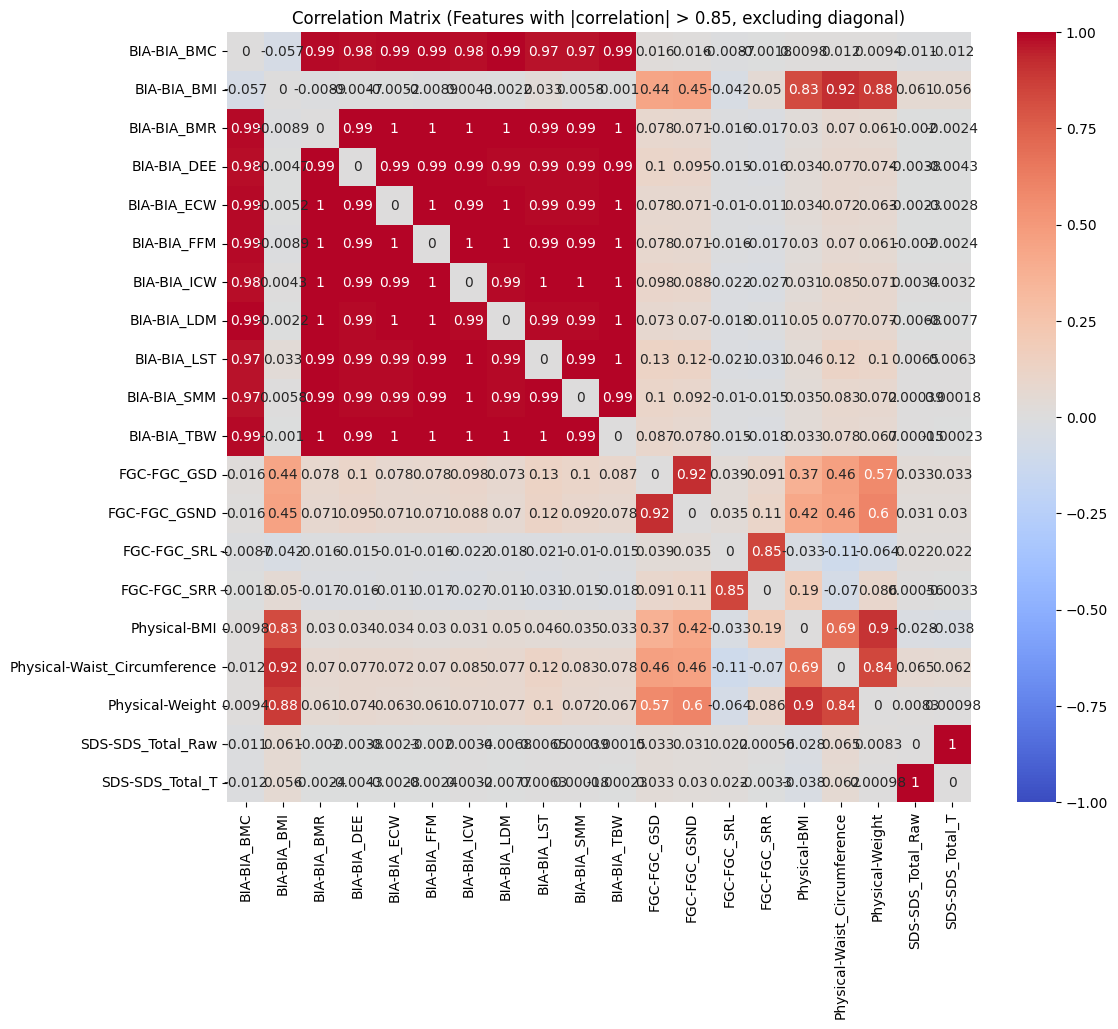

In [35]:
PrintCorrelationMatrix(X_train, 0.85)

Bia + Physical BMI provarle tutte e vedere la migliore
FGC-FGC_SRL, FGC-FGC_SRR prendere la media
togliere FGC-FGC_SRL_Zone
prendere SDS-SDS_Total_T ed escludere SDS-SDS_Total_Raw
Tutte le colonne PreInt_EduHx-Season le togliamo, sono colonne che indicano quando sono stati raccolti dati di interesse, ma di per sè sapere quando questi vengono raccolti non ce ne ciava un cazzo :)



In [36]:
def data_cleaning(df):
    # per le seguenti colonne teniamo solo BIA-BIA_BMI
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM',
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    # Elimina le colonne non necessarie
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Tra Physical-Waist_Circumference, Physical-Weight e Physical-BMI teniamo l'ultima
    to_remove = ['Physical-Waist_Circumference', 'Physical-Weight']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])
    
    # Calcola la media tra 'FGC-FGC_SRL' e 'FGC-FGC_SRR'
    # FGC-FGC_SRL -> Forza di presa della mano dominante (misurata con un dinamometro)
    # FGC-FGC_SRR -> Forza di presa della mano non dominante (misurata con un dinamometro)
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns) and 'FGC-FGC_SRM' not in df.columns:
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])

    # Calcola la media tra 'FGC-FGC_GSD' e 'FGC-FGC_GSND'
    # FGC-FGC_GSD -> Forza di presa della mano dominante (misurata specificamente per la forza)
    # FGC-FGC_GSND -> Forza di presa della mano non dominante (misurata specificamente per la forza)
    if {'FGC-FGC_GSD', 'FGC-FGC_GSND'}.issubset(df.columns) and 'FGC-FGC_GSM' not in df.columns:
        df['FGC-FGC_GSM'] = (df['FGC-FGC_GSD'] + df['FGC-FGC_GSND']) / 2
        df = df.drop(columns=['FGC-FGC_GSD', 'FGC-FGC_GSND'])

    # Rimuovi tutte le colonne _Zone, sono delle categorizzazioni di altre colonne
    zone_col = [col for col in df.columns if '_Zone' in col]
    df = df.drop(columns=zone_col)
    print(f"Colonne _Zone rimosse: {zone_col}")

    # Mantieni solo 'SDS-SDS_Total_T' e rimuovi 'SDS-SDS_Total_Raw'
    # SDS-SDS_Total_T -> Punteggio T totale della scala di disturbi del sonno (punteggio standardizzato per la qualità del sonno)
    if 'SDS-SDS_Total_Raw' in df.columns:
        df = df.drop(columns=['SDS-SDS_Total_Raw'])

    # Tra BIA-BIA_BMI e Physical-BMI teniamo solo Physical-BMI,
    # BIA-BIA_BMI -> valore calcolato sulla base del peso e dell'altezza
    # Physical-BMI -> misura ottenuta tramite macchinario
    to_remove = ['BIA-BIA_BMI']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])
    
    return df

X_train = data_cleaning(X_train)
X_test = data_cleaning(X_test)


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


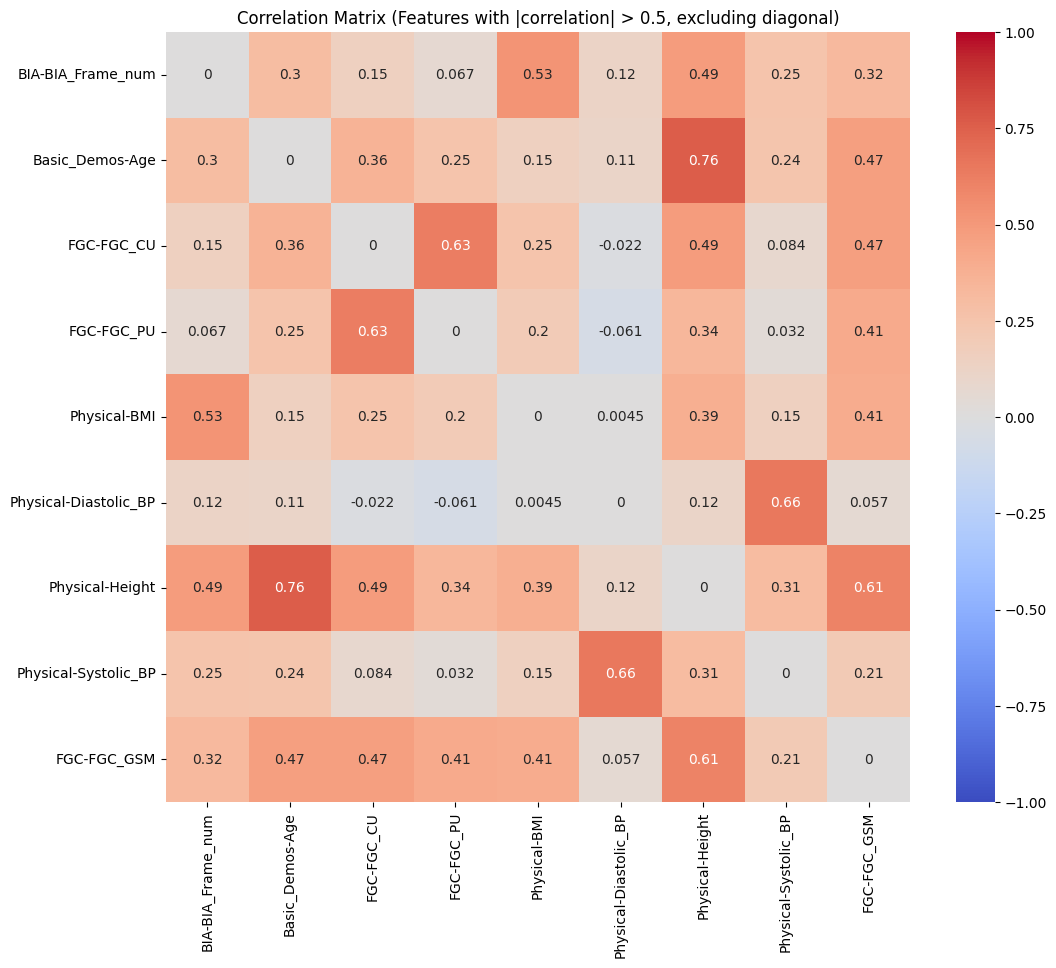

In [37]:
PrintCorrelationMatrix(X_train, 0.50)

In [38]:
X_train

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,...,PAQ_C-PAQ_C_Total,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-FGC_GSM
1456,-0.273764,0.004038,0.279498,1.514059,0.352608,1.300063,1.280895,-0.769415,-0.629012,0.909792,...,-0.446881,2.539875,0.099277,-0.775622,2.281742,-0.174875,0.851535,-0.667288,-0.511049,1.981421
1563,-0.283491,-0.010958,0.035154,0.877464,0.202010,1.064929,1.561620,-0.769415,-0.672801,-0.614955,...,-0.519259,1.044228,0.319720,-0.336476,1.144350,0.997572,0.623471,-0.968230,-2.554852,1.117630
2591,-0.020848,-0.029964,-0.366946,-0.531341,-0.064769,-0.492832,-0.403454,1.299688,0.002426,-0.627661,...,-0.595819,-3.779707,0.197742,0.370548,-0.415817,-0.011318,0.906270,0.310771,-0.211407,-0.985027
2966,-1.606437,-0.022640,-0.124909,0.606361,0.147389,0.374224,1.280895,1.299688,-0.326430,0.316835,...,-0.711290,0.618651,-0.071200,-0.355506,0.943634,-0.095148,1.763790,0.310771,1.532754,1.221348
1988,-1.606437,-0.036539,-0.433989,-0.421180,-0.050021,-1.095362,-0.403454,-0.769415,-0.716590,-0.953788,...,0.616968,-1.007933,-0.268129,-0.116903,-0.260663,-0.643854,0.851535,2.342124,-0.656883,-1.103642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.339072,-0.053867,0.232263,-0.224171,-0.018816,0.374224,-0.122729,-0.769415,0.991183,0.740376,...,0.938648,-0.008828,-0.929460,0.175861,0.040411,-1.230077,-0.972975,0.085065,-1.386965,-0.651742
705,0.339072,-0.026325,0.007399,-0.042690,0.011347,0.374224,-0.122729,-0.769415,-0.234910,0.740376,...,0.771374,-0.037957,0.172758,-1.727104,0.207674,-0.526609,-0.972975,-0.892994,1.678892,-0.789085
1220,1.311826,-0.015946,0.290836,0.154611,0.064890,0.374224,1.561620,1.299688,-0.334750,-0.699663,...,0.001490,0.528094,0.025796,0.468624,0.910181,-0.643854,0.851535,0.461241,1.386920,0.753728
1831,0.339072,0.017634,-0.231280,-0.111534,-0.019196,0.374224,-0.684179,1.299688,-0.672801,-0.276122,...,-0.785559,-0.393713,0.025796,-0.409667,-0.762454,-0.409364,-0.972975,-0.291112,0.291797,-0.810217


## Data preparation

In [39]:
from cleaning.rfecv_selection import rfecv_selection

column_number, selected_features = rfecv_selection(X_train, y_train)

# Mostra il numero delle feature selezionate
print(f"Numero di feature selezionate: {column_number}")

# Mostra le feature selezionate
print(f"Feature selezionate: {selected_features}")


Numero di feature selezionate: 22
Feature selezionate: ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM']


In [40]:
from cleaning.rfe_selection import rfe_selection

column = rfe_selection(X_train, y_train, column_number)

data = pd.concat([X_train[column], y_train], axis=1)
column
# Sia RFECV che RFE hanno restituito le features nello stesso ordine

Index(['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'Basic_Demos-Age',
       'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU',
       'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height',
       'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday',
       'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM'],
      dtype='object')

In [41]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print("Distribuzione delle etichette nel training set:")
print(train_counts)

print("Distribuzione delle etichette nel test set:")
print(test_counts)


Distribuzione delle etichette nel training set:
sii
0.0    1607
1.0     955
2.0     422
3.0      40
Name: count, dtype: int64
Distribuzione delle etichette nel test set:
sii
0.0    494
1.0    167
2.0     91
3.0      5
Name: count, dtype: int64


In [42]:
# Il dataset è fortemente sbilanciato
# Come metrica per la valutazione dei modelli usiamo una media ponderata in base alla proporzione inversa 
# della quantità di classi, in modo che anche se una classe ha poche istanze tenterà di ottenere una media generale buona

# utilizziamo class_weight="balanced"

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer

def grid_search_rf(X_train, y_train):
    model = RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced"
    )

    param_grid = {
        'max_depth': [10, 20, 40, 60, 80, 100, 150],
        'min_samples_leaf': [1, 2, 3, 4, 5]
    }

    # Usa la balanced_accuracy_score come metrica
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=10
    )

    # Esegui la ricerca
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

# Esegui il grid search
parameters = grid_search_rf(X_train, y_train)


Best parameters: {'max_depth': 100, 'min_samples_leaf': 1}


Train Accuracy: 1.0000
Test Accuracy: 0.6433
Train Balanced Accuracy: 1.0000
Test Balanced Accuracy: 0.3194


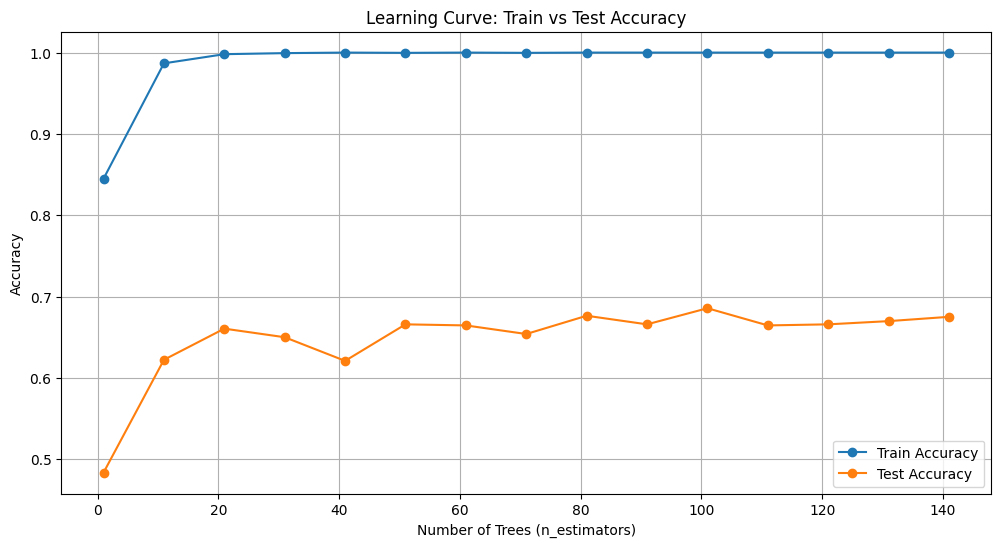

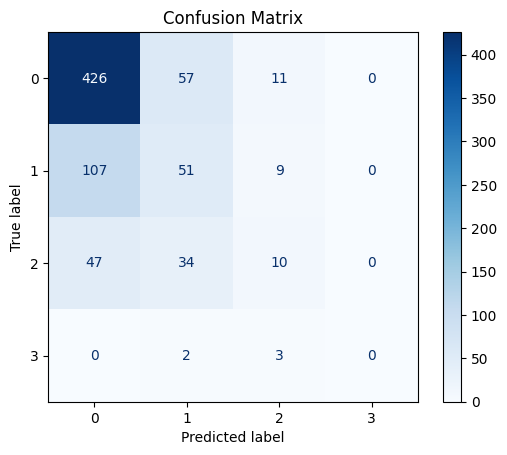

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils.print_confusion_matrix import print_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import plot_tree

model = RandomForestClassifier(**parameters)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test[X_train.columns])

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")


n_estimators_range = range(1, 150, 10)
train_accuracies = []
test_accuracies = []

for n in n_estimators_range:
    model = RandomForestClassifier(
        max_depth=parameters['max_depth'],
        min_samples_leaf=parameters['min_samples_leaf'],
        n_estimators=n,
        class_weight="balanced"
    )
    model.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

# Grafico delle accuratezze per il numero di alberi
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Train vs Test Accuracy")
plt.legend()
plt.grid()
plt.show()

print_confusion_matrix(y_test, y_test_pred)

In [ ]:
# rimane una forte predominanza per la feature con classe 0
# Proviamo con un modello ANN

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

model = models.Sequential()

hidden_layer = 1

model.add(Input(shape=(X_train.shape[1],)))

for i in range(0, hidden_layer):
    model.add(layers.Dense(16,activation='softmax'))
    model.add(Dropout(0.5))

model.add(layers.Dense(4,activation='softmax'))

model.compile( optimizer=optimizers.Adam(learning_rate=0.9),
               loss='categorical_crossentropy',       # loss function
               metrics=['acc'] )   # additional quality measure

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
class_weights = {
    0: 0.5,  # Classe 1
    1: 2.0,  # Classe 2
    2: 3.0,  # Classe 3
    3: 4.0   # Classe 4
}


# train the network
history = model.fit( x=X_train, # training examples
           y=y_train_cat, # desired output
           epochs=20,
           verbose=1,
           validation_data=(X_test, y_test_cat),
           class_weight=class_weights,
           callbacks=[lr_scheduler, early_stopping]);

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['acc'], label='Training Accuracy', color='green')
if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predire i risultati su X_test
y_pred_prob = model.predict(X_test)  # Probabilità per ciascuna classe
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe con la probabilità più alta

# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

In [ ]:
# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Mostrare alcune predizioni
for i in range(5):
    print(f"True label: {y_test_original[i]}, Predicted: {y_pred[i]}, Probabilities: {y_pred_prob[i]}")



In [ ]:
from utils.print_confusion_matrix import print_confusion_matrix


print_confusion_matrix(y_test_original, y_pred)

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import classification_report

def macro_f1_score(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    return report['macro avg']['f1-score']

def evaluate_model(class_weights):
    model = models.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='softmax'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.9),
        loss='categorical_crossentropy',
        metrics=['acc']
    )

    # Addestra il modello
    history = model.fit(
        X_train, y_train_cat,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test_cat),
        class_weight=class_weights
    )
    
    # Calcola le probabilità e le etichette predette
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_original = np.argmax(y_test_cat, axis=1)
   
    # Genera il classification report con macro average
    report = classification_report(y_test_original, y_pred, output_dict=True, zero_division=1)
    
    # Ottieni il f1-score macro direttamente dal classification_report
    macro_f1 = report['macro avg']['f1-score']
    
    return macro_f1


class_weights_values = {
    0: [0.7, 0.8, 0.85, 0.9, 1],
    1: [1, 1.2, 1.4, 1.5, 1.6, 1.8],
    2: [1.7, 1, 1.2, 1.5],
    3: [1.2, 1.4, 1.5, 1.6, 1.8]
}

param_grid = [dict(zip(class_weights_values.keys(), comb)) for comb in product(*class_weights_values.values())]

# Esegui la ricerca a griglia manuale
best_score = 0
best_params = None

print("start training...")
for weights in param_grid:
    score = evaluate_model(weights)
    print(f"Pesi: {weights} - Macro: {score:.4f}")
    if score > best_score:
        best_score = score
        best_params = weights

print(f"Migliore f1-pesato: {best_score:.4f} con pesi: {best_params}")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

model = models.Sequential()

hidden_layer = 1

model.add(Input(shape=(X_train.shape[1],)))

for i in range(0, hidden_layer):
    model.add(layers.Dense(16,activation='softmax'))
    model.add(Dropout(0.5))

model.add(layers.Dense(4,activation='softmax'))

model.compile( optimizer=optimizers.Adam(learning_rate=0.9),
               loss='categorical_crossentropy',       # loss function
               metrics=['acc'] )   # additional quality measure

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

print(f" weight: {best_params}")
# train the network
history = model.fit( x=X_train, # training examples
           y=y_train_cat, # desired output
           epochs=15,
           verbose=1,
           validation_data=(X_test, y_test_cat),
           class_weight= best_params,
           callbacks=[lr_scheduler, early_stopping]);

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['acc'], label='Training Accuracy', color='green')
if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predire i risultati su X_test
y_pred_prob = model.predict(X_test)  # Probabilità per ciascuna classe
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe con la probabilità più alta

# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

print(f"Unweight accuracy: {classification_report(y_test_original, y_pred, output_dict=True, zero_division=1)['macro avg']['f1-score']}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(y_test_original, y_pred)

# Visualizzare la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(4))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
